In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: '%.3f' % x)
pd.set_option("display.width", 500)

In [2]:
def load_application_train():
    data = pd.read_csv("datasets/application_train.csv")
    return data

In [3]:
def load():
    data = pd.read_csv("datasets/titanic.csv")
    return data

In [4]:
def catch_outliers(dataframe, num_col, q1=0.25, q3=0.75):
    quartile1 = dataframe[num_col].quantile(q1)
    quartile3 = dataframe[num_col].quantile(q3)
    iqr = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * iqr
    low_limit = quartile1 - 1.5 * iqr

    # outliers = [dataframe[(dataframe[num_col] < low) | (dataframe[num_col] > up)]]
    return low_limit, up_limit


def check_outlier(dataframe, num_col):
    low_limit, up_limit = catch_outliers(dataframe, num_col)

    if dataframe[(dataframe[num_col] < low_limit) | (dataframe[num_col] > up_limit)].any(axis=None):
        return True
    else:
        return False

    
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.

    Parameters
    ----------
    dataframe: dataframe
        Değişken isimleri alınmak istenen dataframe'dir.
    cat_th: int, float
        Numerik fakat kategorik olan değişkenler için sınıf eşik değeri.
    car_th: int, float
        Kategorik fakat kardinal değişkenler için sınıf eşik değeri.

    Returns
    -------
    cat_cols: list
        Kategorik değişken listesi.
    num_cols: list
        Numerik değişken listesi.
    cat_but_car: list
        Kategorik görünümlü kardinal değişken listesi.

    Notes
    ------
    cat_cols + num_cols + cat_but_car = toplam değişken sayısı
    num_but_cat, cat_cols'un içerisinde.

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["object", "category", "bool"]]

    num_but_cats = [col for col in dataframe.columns if dataframe[col].dtypes in ["int64", "float64"] and
                    dataframe[col].nunique() < cat_th]

    cat_but_cars = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["object", "category"] and
                    dataframe[col].nunique() > car_th]

    cat_cols = cat_cols + num_but_cats

    cat_cols = [col for col in cat_cols if col not in cat_but_cars]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["int64", "float64"]]
    num_cols = [col for col in num_cols if col not in num_but_cats]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_cars)}")
    print(f"num_but_cat: {len(num_but_cats)}")

    return cat_cols, num_cols, cat_but_cars


def reach_outliers(dataframe, num_col, index=False):
    up_limit, low_limit = catch_outliers(dataframe, num_col)

    if len(dataframe[(dataframe[num_col] < low_limit) | (dataframe[num_col] > up_limit)]) > 10:
        print(dataframe[(dataframe[num_col] < low_limit) | (dataframe[num_col] > up_limit)].head())
    else:
        print(dataframe[(dataframe[num_col] < low_limit) | (dataframe[num_col] > up_limit)])

    if index:
        return dataframe[(dataframe[num_col] < low_limit) | (dataframe[num_col] > up_limit)].index


def remove_outliers(dataframe, num_col):
    up_limit, low_limit = catch_outliers(dataframe, num_col)
    df_without_outliers = dataframe[~((dataframe[num_col] < low_limit) | (dataframe[num_col] > up_limit))]

    return df_without_outliers


def replace_with_thresholds(dataframe, num_col):
    low_limit, up_limit = catch_outliers(dataframe, num_col)

    dataframe.loc[(dataframe[num_col] < low_limit), num_col] = low_limit
    dataframe.loc[(dataframe[num_col] > up_limit), num_col] = up_limit

# Encoding

## Label Encoding

Label Encoder, bir değişken içerisinde iki sınıf varsa bu sınıfları 0 ve 1 olarak encode işlemi yapar.

In [5]:
df = load()

In [6]:
df["Sex"].head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

In [7]:
le = LabelEncoder()

In [8]:
le.fit_transform(df["Sex"])[0:5] # sex kolonunu encode et ve ilk 5 satırını yazdır

array([1, 0, 0, 0, 1])

Label Encoder, değişken içerisindeki sınıfların alfabetik sırasına göre 0'dan başlayarak numaranlandırma yapar. Yani yukarıdaki örnekte, sex değişkeni içerisinde 0.indexte male, 1.indexte female vardı. Female alfabetik sıraya göre male'den önce geldiğinden dolayı female -> 0, male -> 1 oldu.

Diyelimki daha sonrasında biz 0'ın hangi sınıf olduğunu ve 1'in hangi sınıf olduğunu unuttuk. Bunlara karşılık gelen değerleri görmek için inverse_transform metodunu kullanırız:

In [9]:
le.inverse_transform([0,1]) # 0 ve 1 değerlerinin asıl sınıfları neler?

array(['female', 'male'], dtype=object)

Bu işlemi tek tek bütün kolonlar için yapmak zaman alacağından bri fonksiyon oluşturabiliriz:

In [10]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

Fonksiyonumuzu oluşturduk fakat bir problem var. Bir dataframe içerisinde yüzlerce değişken olduğu zaman, bunların arasından binary_col'ları (yani sadece 2 sınıf içeren kategorik değişkenleri) nasıl seçeriz?

Bunun için de bu deeğişkenleri dataframeden ayıklamak için list comprehension kullanırız:

In [11]:
binary_cols = [col for col in df.columns if df[col].dtypes not in ['int64', 'float64'] and df[col].nunique() == 2]
#df içerisindeki değişkenlerden tipi int ve float olmayan ve içerisinde 2 sınıf olan değişkenleri seç

In [12]:
binary_cols

['Sex']

In [13]:
label_encoder(df, binary_cols).head()

C:\Users\btskd\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",1,35.000,0,0,373450,8.050,NaN,S


Yukarıdaki df'e baktığımız zaman sex değişkeninin 0 ve 1 olarak encode edildiğini görebiliriz.

## One Hot Encoding

One Hot Encoderda, bir değişkenin tüm sınıfları tek tek değişkene dönüştürülür. Bu değişkenler tüm gözlem birimlerinde 0 ile doldurulur, fakat ilgili gözlemde, o gözlem birimi orjinal değişkende hangi sınıfa aitse, o sınıfın değişkeni 1 ile doldurulur.

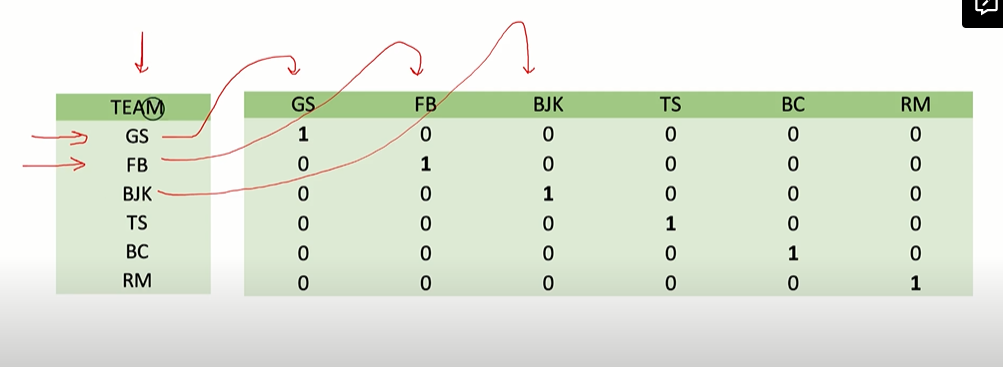

Burada dikkat edilmesi gerekilen bir husus var. One-Hot Encoding'i uygularken kullanacağımız metodlarda drop_first diyerek ilk sınıfı drop etmiş olarak ortaya çıkacak olan dummy değişken tuzağından kurtuluyoruz.

In [14]:
df = load()

In [15]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [16]:
df["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Embarked değişkeni, 3 sınıftan oluşan nominal bir değişkendir. Yani sınıflar arasında herhangi bir seviye farkı yoktur. 

Bu değişkene one hot encoding yapmamız gerekiyor. Bunun için pandas kütüphanesinden get_dummies metodunu kullanacağız.

In [17]:
pd.get_dummies(df, columns=["Embarked"]).head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,0,0,1


Görüldüğü üzere orjinal Embarked değişkeni dfden çıkartıldı ve onun yerine bu değişken içerisindeki sınıflardan oluşan kolonlar eklendi. Sonrasında dummy değişken tuzağına düşmemek için drop_first parametresini kullanmamız gerekiyor. (dummy değişken araştır!)

In [18]:
pd.get_dummies(df, columns=["Embarked"], drop_first=True).head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,0,1


Embarked değişkeni içerisindeki nan değerler için de bir sınıf oluşturulmasını istersek:

In [19]:
pd.get_dummies(df, columns=["Embarked"], dummy_na=True).head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,0,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,1,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,0,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,0,0,1,0


get_dummies metodunu kullnarak hem label encoding, hem de one hot encoding işlemini yapabiliriz.

In [20]:
pd.get_dummies(df, columns=["Sex", "Embarked"], drop_first=True).head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.000,1,0,A/5 21171,7.250,NaN,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.000,1,0,PC 17599,71.283,C85,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.000,0,0,STON/O2. 3101282,7.925,NaN,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.000,1,0,113803,53.100,C123,0,0,1
4,5,0,3,"Allen, Mr. William Henry",35.000,0,0,373450,8.050,NaN,1,0,1


Bu işlemler için bir fonksiyon yazalım:

In [21]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    # fonksiyona girilen dataframe içerisinden kategorik değişkenleri one hot encoding işlemine sokuyoruz
    # sonrasında ana dataframe'e bunu kaydederek fonksiyon sonunda bu df'i döndürüyoruz.
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

Şimdi titanic veri setini baştan çağıralım ve grab_col_names fonksiyonumuzla bu df içerisinden kategorik değişkenleri ayıklayalım.

In [22]:
df = load()

In [23]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4


In [24]:
cat_cols

['Sex', 'Embarked', 'Survived', 'Pclass', 'SibSp', 'Parch']

In [25]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
# sınıf sayısı 10'dan küçük veya eşit, ve 2 den büyük olan değişkenleri seç

In [26]:
ohe_cols

['Pclass', 'SibSp', 'Parch', 'Embarked']

Neden sonrasında ohe_cols diye ayırdık? Çünkü genel olarak kategorik değişkenleri içerisinden zaten sex değişkenini daha önce encodelamıştık. Survived değişkeni de zaten bizim bağımlı değişkenimiz. Dolayısıyla bu iki değişken için encode işlemi yapmaya gerek yok. Bundan dolayı encode edilecek değişkenleri bizim kendimiz seçmemiz gerekiyor. Bunun içinde yukarıdaki list comprehension yapısını kullandık.

In [27]:
one_hot_encoder(df, ohe_cols).head()

,PassengerId,Survived,Name,Sex,Age,Ticket,Fare,Cabin,Pclass_2,Pclass_3,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",male,22.000,A/5 21171,7.250,NaN,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,PC 17599,71.283,C85,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1,"Heikkinen, Miss. Laina",female,26.000,STON/O2. 3101282,7.925,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,113803,53.100,C123,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",male,35.000,373450,8.050,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


 Bu işlem kalıcı değil. Eğer kalıcı olmasını istiyorsak yukarıdaki kodu df= şeklinde yazmamız gerekiyor.

## Rare Encoding

Burada kategorik değişken içerisindeki sınıfların her bir tanesinin countları hesaplanır. 

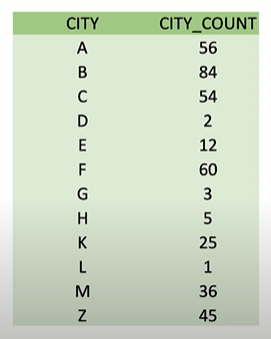

Sayıca az olan (ör. D,G) sınıflar, one hot encoding işlemi yapıldıktan sonra çok az gözlemde 1 değeri döndürecek. Bunlar herhangi bir bilgi taşımıyor olacaklar. Bundan dolayı sayıca az olan sınıfları kendi aralarında toplayıp "rare" adında birleştirerek böyle bir değişken oluşturabiliriz.

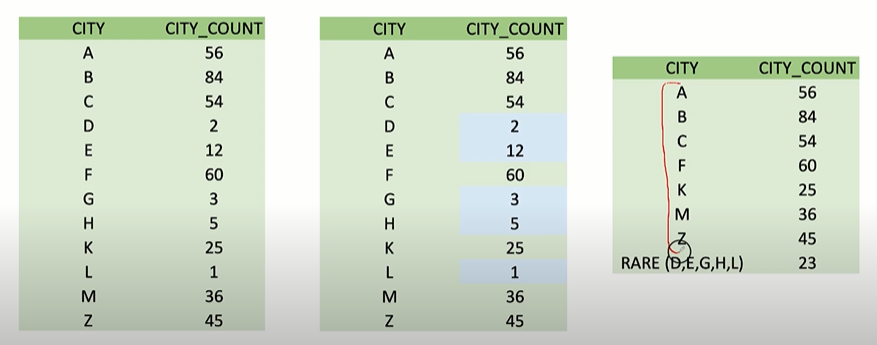

Burada sınır olarak kaç tane olması gerektiğini biz belirleyebiliriz. Yukarıdaki örnekte 25'ten az olan sınıflar RARE içerisinde birleştirilerek bir değişken oluşturuldu.

Bu kısımda 3 adım atacağız:
1. Kategorik değişkenlerin azlık çokluk durumunun analiz edilmesi.
2. Rare kategoriler ile bağımlı değişken arasındaki ilişkinin analiz edilmesi.
3. Rare encoder yazacağız.

### 1. Kategorik değişkenlerin azlık çokluk durumunun analiz edilmesi.

In [28]:
df = load_application_train()

In [29]:
df["NAME_EDUCATION_TYPE"].value_counts()

Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64

In [30]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 307511
Variables: 122
cat_cols: 54
num_cols: 67
cat_but_car: 1
num_but_cat: 39


In [31]:
cat_cols

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'TARGET',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOC

Burada yeni bir fonksiyona ihtiyacımız var. Bu fonksiyon kategorik sınıfları ve sınıfların oranları getirsin.

In [32]:
def cat_summary(dataframe, col_name, plot=False):
    # kategorik değişkenin sınıflarının count değerleri ve bu sınıfların oranlarını içeren bir df oluşturulur
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                       "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    
    # eğer plot true ise, değişkenlerdeki sınıfların grafikleri oluşturulur
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

In [33]:
for col in cat_cols:
    cat_summary(df, col)

                 NAME_CONTRACT_TYPE  Ratio
Cash loans                   278232 90.479
Revolving loans               29279  9.521
##########################################
     CODE_GENDER  Ratio
F         202448 65.834
M         105059 34.164
XNA            4  0.001
##########################################
   FLAG_OWN_CAR  Ratio
N        202924 65.989
Y        104587 34.011
##########################################
   FLAG_OWN_REALTY  Ratio
Y           213312 69.367
N            94199 30.633
##########################################
                 NAME_TYPE_SUITE  Ratio
Unaccompanied             248526 80.819
Family                     40149 13.056
Spouse, partner            11370  3.697
Children                    3267  1.062
Other_B                     1770  0.576
Other_A                      866  0.282
Group of people              271  0.088
##########################################
                      NAME_INCOME_TYPE  Ratio
Working                         158774 51.632
C

   FLAG_DOCUMENT_13  Ratio
0            306427 99.647
1              1084  0.353
##########################################
   FLAG_DOCUMENT_14  Ratio
0            306608 99.706
1               903  0.294
##########################################
   FLAG_DOCUMENT_15  Ratio
0            307139 99.879
1               372  0.121
##########################################
   FLAG_DOCUMENT_16  Ratio
0            304458 99.007
1              3053  0.993
##########################################
   FLAG_DOCUMENT_17  Ratio
0            307429 99.973
1                82  0.027
##########################################
   FLAG_DOCUMENT_18  Ratio
0            305011 99.187
1              2500  0.813
##########################################
   FLAG_DOCUMENT_19  Ratio
0            307328 99.940
1               183  0.060
##########################################
   FLAG_DOCUMENT_20  Ratio
0            307355 99.949
1               156  0.051
##########################################
   FLAG_

### 2. Rare kategoriler ile bağımlı değişken arasındaki ilişkinin analiz edilmesi.

In [34]:
df["NAME_INCOME_TYPE"].value_counts()

Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

In [35]:
df.groupby("NAME_INCOME_TYPE")["TARGET"].mean()

NAME_INCOME_TYPE
Businessman            0.000
Commercial associate   0.075
Maternity leave        0.400
Pensioner              0.054
State servant          0.058
Student                0.000
Unemployed             0.364
Working                0.096
Name: TARGET, dtype: float64

Bu tarz analiz işlemlerini otomatik yapabilmek için tüm bu işlemleri içeren bir fonksiyon yazarız.

In [36]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts())) # değişkenin içerisinde kaç tane sınıf var?
        
        # değişkendeki sınıfların toplamları, oranları ve target değişkenine göre oranlarını veren dataframe
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                           "RATIO": dataframe[col].value_counts() / len(dataframe),
                           "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

In [37]:
rare_analyser(df, "TARGET", cat_cols)

NAME_CONTRACT_TYPE : 2
                     COUNT  RATIO  TARGET_MEAN
NAME_CONTRACT_TYPE                            
Cash loans          278232  0.905        0.083
Revolving loans      29279  0.095        0.055


CODE_GENDER : 3
              COUNT  RATIO  TARGET_MEAN
CODE_GENDER                            
F            202448  0.658        0.070
M            105059  0.342        0.101
XNA               4  0.000        0.000


FLAG_OWN_CAR : 2
               COUNT  RATIO  TARGET_MEAN
FLAG_OWN_CAR                            
N             202924  0.660        0.085
Y             104587  0.340        0.072


FLAG_OWN_REALTY : 2
    COUNT  RATIO  TARGET_MEAN
N   94199  0.306        0.083
Y  213312  0.694        0.080


NAME_TYPE_SUITE : 7
                  COUNT  RATIO  TARGET_MEAN
Children           3267  0.011        0.074
Family            40149  0.131        0.075
Group of people     271  0.001        0.085
Other_A             866  0.003        0.088
Other_B            1770  0.006    

    COUNT  RATIO  TARGET_MEAN
0  306308  0.996        0.081
1    1203  0.004        0.062


FLAG_DOCUMENT_12 : 2
    COUNT  RATIO  TARGET_MEAN
0  307509  1.000        0.081
1       2  0.000        0.000


FLAG_DOCUMENT_13 : 2
    COUNT  RATIO  TARGET_MEAN
0  306427  0.996        0.081
1    1084  0.004        0.028


FLAG_DOCUMENT_14 : 2
    COUNT  RATIO  TARGET_MEAN
0  306608  0.997        0.081
1     903  0.003        0.033


FLAG_DOCUMENT_15 : 2
    COUNT  RATIO  TARGET_MEAN
0  307139  0.999        0.081
1     372  0.001        0.030


FLAG_DOCUMENT_16 : 2
    COUNT  RATIO  TARGET_MEAN
0  304458  0.990        0.081
1    3053  0.010        0.049


FLAG_DOCUMENT_17 : 2
    COUNT  RATIO  TARGET_MEAN
0  307429  1.000        0.081
1      82  0.000        0.024


FLAG_DOCUMENT_18 : 2
    COUNT  RATIO  TARGET_MEAN
0  305011  0.992        0.081
1    2500  0.008        0.057


FLAG_DOCUMENT_19 : 2
    COUNT  RATIO  TARGET_MEAN
0  307328  0.999        0.081
1     183  0.001        0.066


FLAG

### 3. Rare encoder'ın yazılması.

In [38]:
def rare_encoder(dataframe, rare_perc):
    # dataframe'in kopyasını aldık
    temp_df = dataframe.copy()
    
    # eğer değişken kategorikse ve içerisindeki sınıflardan herhangi birisinin oranı rare_perc'de verilen orandan az ise 
    # bu değişkeni rare_columns'a ata
    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O' and 
                    (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]
    
    for var in rare_columns: # seçilen rare değişkenler içerisinde gez
        tmp = temp_df[var].value_counts() / len(temp_df) # temp_df de var değişkeninin oranını al
        rare_labels = tmp[tmp < rare_perc].index # eğer alınan oran rare_perc'den küçükse bunun label'ını al
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), "Rare", temp_df[var]) # bu label yerine 'Rare' yazdır
        
    return temp_df

In [39]:
new_df = rare_encoder(df, 0.01)

In [40]:
rare_analyser(new_df, "TARGET", cat_cols)

NAME_CONTRACT_TYPE : 2
                     COUNT  RATIO  TARGET_MEAN
NAME_CONTRACT_TYPE                            
Cash loans          278232  0.905        0.083
Revolving loans      29279  0.095        0.055


CODE_GENDER : 3
              COUNT  RATIO  TARGET_MEAN
CODE_GENDER                            
F            202448  0.658        0.070
M            105059  0.342        0.101
Rare              4  0.000        0.000


FLAG_OWN_CAR : 2
               COUNT  RATIO  TARGET_MEAN
FLAG_OWN_CAR                            
N             202924  0.660        0.085
Y             104587  0.340        0.072


FLAG_OWN_REALTY : 2
    COUNT  RATIO  TARGET_MEAN
N   94199  0.306        0.083
Y  213312  0.694        0.080


NAME_TYPE_SUITE : 5
                  COUNT  RATIO  TARGET_MEAN
Children           3267  0.011        0.074
Family            40149  0.131        0.075
Rare               2907  0.009        0.094
Spouse, partner   11370  0.037        0.079
Unaccompanied    248526  0.808    

FLAG_DOCUMENT_20 : 2
    COUNT  RATIO  TARGET_MEAN
0  307355  0.999        0.081
1     156  0.001        0.083


FLAG_DOCUMENT_21 : 2
    COUNT  RATIO  TARGET_MEAN
0  307408  1.000        0.081
1     103  0.000        0.136


AMT_REQ_CREDIT_BUREAU_HOUR : 5
        COUNT  RATIO  TARGET_MEAN
0.000  264366  0.860        0.077
1.000    1560  0.005        0.080
2.000      56  0.000        0.107
3.000       9  0.000        0.000
4.000       1  0.000        0.000


AMT_REQ_CREDIT_BUREAU_DAY : 9
        COUNT  RATIO  TARGET_MEAN
0.000  264503  0.860        0.077
1.000    1292  0.004        0.097
2.000     106  0.000        0.104
3.000      45  0.000        0.044
4.000      26  0.000        0.115
5.000       9  0.000        0.000
6.000       8  0.000        0.000
8.000       1  0.000        0.000
9.000       2  0.000        0.000


AMT_REQ_CREDIT_BUREAU_WEEK : 9
        COUNT  RATIO  TARGET_MEAN
0.000  257456  0.837        0.077
1.000    8208  0.027        0.078
2.000     199  0.001        0.10

## Feature Scaling

### StandardScaler

Klasik standartlaştırma. Ortalamayı çıkar, standart sapmaya böl. z = (x-u)/s

In [41]:
df = load()

In [42]:
scaler = StandardScaler()

In [45]:
df["Age_standard_scaler"] = scaler.fit_transform(df["Age"].values.reshape(-1,1))

In [47]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_standard_scaler
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S,-0.530
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C,0.572
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S,-0.255
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S,0.365
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S,0.365


### RobustScaler

Medyanı çıkar iqr'a böl. Robust scaler, standard scaler'a göre aykırı değerlere karşı dayanıklı olduğundan dolayı daha tercih edilebilir olabilir. Fakat yaygın bir kullanım alanı yoktur.

In [48]:
scaler = RobustScaler()

In [50]:
df["Age_robust_scaler"] = scaler.fit_transform(df["Age"].values.reshape(-1,1))

In [51]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.000,446.000,257.354,1.000,223.500,446.000,668.500,891.000
Survived,891.000,0.384,0.487,0.000,0.000,0.000,1.000,1.000
Pclass,891.000,2.309,0.836,1.000,2.000,3.000,3.000,3.000
Age,714.000,29.699,14.526,0.420,20.125,28.000,38.000,80.000
SibSp,891.000,0.523,1.103,0.000,0.000,0.000,1.000,8.000
Parch,891.000,0.382,0.806,0.000,0.000,0.000,0.000,6.000
Fare,891.000,32.204,49.693,0.000,7.910,14.454,31.000,512.329
Age_standard_scaler,714.000,0.000,1.001,-2.017,-0.660,-0.117,0.572,3.465
Age_robust_scaler,714.000,0.095,0.813,-1.543,-0.441,0.000,0.559,2.909


Sonuçlara baktığımız zaman robust scaler'ın ortalaması ve medyanı standard scaler'a göre daha farklı bir konumda. Bunun sebebi robust scaler'ın aykırı değerlerden etkilenmiyor olmasıdır. 

### MinMaxScaler

Verilen 2 değer arasında değişken dönüşümü

In [52]:
scaler = MinMaxScaler()

In [54]:
df["Age_min_max_scaler"] = scaler.fit_transform(df["Age"].values.reshape(-1,1))

In [55]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.000,446.000,257.354,1.000,223.500,446.000,668.500,891.000
Survived,891.000,0.384,0.487,0.000,0.000,0.000,1.000,1.000
Pclass,891.000,2.309,0.836,1.000,2.000,3.000,3.000,3.000
Age,714.000,29.699,14.526,0.420,20.125,28.000,38.000,80.000
SibSp,891.000,0.523,1.103,0.000,0.000,0.000,1.000,8.000
Parch,891.000,0.382,0.806,0.000,0.000,0.000,0.000,6.000
Fare,891.000,32.204,49.693,0.000,7.910,14.454,31.000,512.329
Age_standard_scaler,714.000,0.000,1.001,-2.017,-0.660,-0.117,0.572,3.465
Age_robust_scaler,714.000,0.095,0.813,-1.543,-0.441,0.000,0.559,2.909
Age_min_max_scaler,714.000,0.368,0.183,0.000,0.248,0.347,0.472,1.000


### Numeric to Categorical: Sayısal Değişkenleri Kategorik Değişkenlere Çevirme

qcut metodu, bir değişkenin değerlerini küçükten büyüğe sıralar ve çeyrek değerlere göre 5 parçaya böler.

In [56]:
df["Age_qcut"] = pd.qcut(df["Age"], 5)

In [57]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_standard_scaler,Age_robust_scaler,Age_min_max_scaler,Age_qcut
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S,-0.530,-0.336,0.271,"(19.0, 25.0]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C,0.572,0.559,0.472,"(31.8, 41.0]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S,-0.255,-0.112,0.321,"(25.0, 31.8]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S,0.365,0.392,0.435,"(31.8, 41.0]"
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S,0.365,0.392,0.435,"(31.8, 41.0]"
